# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -7.38993645 -1.5
 -0.          0.          6.83172083  5.99607611 -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 50):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
import sys
from collections import deque
import timeit
from datetime import timedelta
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from actor_critic import ActorCritic

g_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def normalize(x):
    return x/(1.e-10+np.linalg.norm(x, ord=2, axis=1, keepdims=True))

In [8]:
def collect_trajectories(envs, policy, tmax=200, nrand=5, train_mode=False):

    def to_tensor(x, dtype=np.float32):
        return torch.from_numpy(np.array(x).astype(dtype)).to(g_device)

    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]
    value_list=[]
    done_list=[]
    score_list=[]

    env_info = envs.reset(train_mode=train_mode)[brain_name]

    # perform nrand random steps
    for _ in range(nrand):
        action = np.random.randn(num_agents, action_size)
        action = np.clip(action, -1.0, 1.0)
        env_info = envs.step(action)[brain_name]

    score = [0.0, 0.0]
    for t in range(tmax):
        states = normalize(env_info.vector_observations)
        env_actions = []
        #for states in all_states:
        states = to_tensor(states)
        action_est, values = policy(states)
        sigma = nn.Parameter(torch.zeros(action_size))
        dist = torch.distributions.Normal(action_est, F.softplus(sigma).to(g_device))
        actions = dist.sample()
        log_probs = dist.log_prob(actions)
        log_probs = torch.sum(log_probs, dim=-1).detach()
        values = values.detach()
        actions = actions.detach()
        env_actions.append(actions.cpu().numpy())
        
        env_info = envs.step(env_actions)[brain_name]
        #rwrd = [-0.1 if r<=-0.0001 else r for r in env_info.rewards]
        rwrd = [r for r in env_info.rewards]
        score[0] += rwrd[0]
        score[1] += rwrd[1]
        rewards = to_tensor(rwrd)
        dones = to_tensor(env_info.local_done, dtype=np.uint8)
        #for _ in all_states:
        reward_list.append(rewards.unsqueeze(0))
        done_list.append(dones.unsqueeze(0))
        state_list.append(states.unsqueeze(0))
        prob_list.append(log_probs.unsqueeze(0))
        action_list.append(actions.unsqueeze(0))
        value_list.append(values.unsqueeze(0))
        if np.any(dones):
            score_list.append(score)
            score = [0.0,0.0]
            env_info = envs.reset(train_mode=train_mode)[brain_name]

    if np.any(dones)==False:
        score_list.append(score)

    state_list = torch.cat(state_list, dim=0)
    prob_list = torch.cat(prob_list, dim=0)
    action_list = torch.cat(action_list, dim=0)
    reward_list = torch.cat(reward_list, dim=0)
    value_list = torch.cat(value_list, dim=0)
    done_list = torch.cat(done_list, dim=0)

    return prob_list, state_list, action_list, reward_list, value_list, done_list, score_list

In [9]:
def calc_returns(rewards, values, dones):
    n_step = len(rewards)
    n_agent = len(rewards[0])

    # Create empty buffer
    GAE = torch.zeros(n_step,n_agent).float().to(g_device)
    returns = torch.zeros(n_step,n_agent).float().to(g_device)

    # Set start values
    GAE_current = torch.zeros(n_agent).float().to(g_device)

    TAU = 0.95
    discount = 0.99
    values_next = values[-1].detach()
    returns_current = values[-1].detach()
    for irow in reversed(range(n_step)):
        values_current = values[irow]
        rewards_current = rewards[irow]
        gamma = discount * (1. - dones[irow].float())

        # Calculate TD Error
        td_error = rewards_current + gamma * values_next - values_current
        # Update GAE, returns
        GAE_current = td_error + gamma * TAU * GAE_current
        returns_current = rewards_current + gamma * returns_current
        # Set GAE, returns to buffer
        GAE[irow] = GAE_current
        returns[irow] = returns_current

        values_next = values_current

    return GAE, returns

In [10]:
# run your own policy!
policy=ActorCritic(state_size=state_size,
              action_size=action_size,
              shared_layers=[256, 128],
              critic_hidden_layers=[64],
              actor_hidden_layers=[64],
              init_type='xavier-uniform',
              seed=0).to(g_device)

# optim.SGD is also possible
optimizer = optim.Adam(policy.parameters(), lr=3e-4)

24
2
Episode: 10, average score: 0.75
Episode: 20, average score: 1.17
Episode: 30, average score: 1.52
Episode: 40, average score: 1.79
Episode: 50, average score: 2.01
Episode: 60, average score: 2.22
Episode: 70, average score: 2.39
Environment solved in 78 episodes!	Average Score: 2.51
Average Score: 2.51
Elapsed time: 0:06:29.956928
Saving checkpoint!


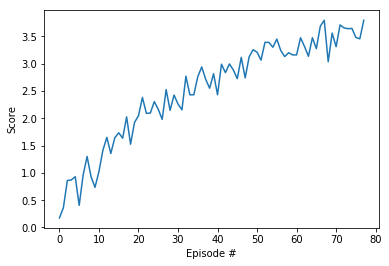

In [11]:
scores_window = deque(maxlen=100)  # last 100 scores

score_goal = 2.5

discount = 0.99
epsilon = 0.1
beta = .01
opt_epoch = 10
episode = 2000
batch_size = 128
tmax = batch_size * 15 #env episode steps

print_per_n = min(10,episode/10)
counter = 0
start_time = timeit.default_timer()

save_scores = []

print(state_size)
print(action_size)

for e in range(episode):
    policy.eval()
    old_probs_lst, states_lst, actions_lst, rewards_lst, values_lst, dones_list, score_list = collect_trajectories(envs=env,
                                                                                                       policy=policy,
                                                                                                       tmax=tmax,
                                                                                                       nrand = 0,
                                                                                                       train_mode=True)

    #avg_score = rewards_lst.sum(dim=0).mean().item()
    avg_score = np.sum(score_list,0).mean()
    scores_window.append(avg_score)
    save_scores.append(avg_score)

    gea, target_value = calc_returns(rewards = rewards_lst,
                                     values = values_lst,
                                     dones=dones_list)
    gea = (gea - gea.mean()) / (gea.std() + 1e-8)

    policy.train()

    # cat all agents
    def concat_all(v):
        if len(v.shape) == 3:
            return v.reshape([-1, v.shape[-1]])
        return v.reshape([-1])

    old_probs_lst = concat_all(old_probs_lst)
    states_lst = concat_all(states_lst)
    actions_lst = concat_all(actions_lst)
    rewards_lst = concat_all(rewards_lst)
    values_lst = concat_all(values_lst)
    gea = concat_all(gea)
    target_value = concat_all(target_value)

    # gradient ascent step
    n_sample = len(old_probs_lst)//batch_size
    idx = np.arange(len(old_probs_lst))
    np.random.shuffle(idx)
    for epoch in range(opt_epoch):
        for b in range(n_sample):
            ind = idx[b*batch_size:(b+1)*batch_size]
            g = gea[ind]
            tv = target_value[ind]
            actions = actions_lst[ind]
            old_probs = old_probs_lst[ind]
            action_est, values = policy(states_lst[ind])
            sigma = nn.Parameter(torch.zeros(action_size))
            dist = torch.distributions.Normal(action_est, F.softplus(sigma).to(g_device))
            log_probs = dist.log_prob(actions)
            log_probs = torch.sum(log_probs, dim=-1)
            entropy = torch.sum(dist.entropy(), dim=-1)

            ratio = torch.exp(log_probs - old_probs)
            ratio_clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
            L_CLIP = torch.mean(torch.min(ratio*g, ratio_clipped*g))
            # entropy bonus
            S = entropy.mean()
            # squared-error value function loss
            L_VF = 0.5 * (tv - values).pow(2).mean()
            # clipped surrogate
            L = -(L_CLIP - L_VF + beta*S)
            optimizer.zero_grad()
            # This may need retain_graph=True on the backward pass
            # as pytorch automatically frees the computational graph after
            # the backward pass to save memory
            # Without this, the chain of derivative may get lost
            L.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(policy.parameters(), 10.0)
            optimizer.step()
            del(L)

    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.998
    
    # display some progress every n iterations
    if (e+1)%print_per_n ==0 :
        print("Episode: {0:d}, average score: {1:.2f}".format(e+1,np.mean(scores_window)), end="\n")
    else:
        print("Episode: {0:d}, score: {1:.2f}".format(e+1, avg_score), end="\r")
    if np.mean(scores_window)<5.0:
        counter = 0# stop if any of the trajectories is done to have retangular lists
    if e>=25 and np.mean(scores_window)>score_goal:
        print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e+1, np.mean(scores_window)))
        break


print('Average Score: {:.2f}'.format(np.mean(scores_window)))
elapsed = timeit.default_timer() - start_time
print("Elapsed time: {}".format(timedelta(seconds=elapsed)))
print("Saving checkpoint!")
# save your policy!
torch.save(policy.state_dict(), 'checkpoint.pth')

# save data
import pickle
pickle.dump(save_scores, open( "saved_scors.p", "wb" ) )

# plot scores
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(save_scores)), save_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('scores_plot.png')
plt.show()

When finished, you can close the environment.

In [ ]:
env.close()